In [ ]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
import cv2
import random
import albumentations as A
import random
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from keras import backend as K
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.resnet import preprocess_input

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('../data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('../train_source_images.txt')
validate_ids = load_text_ids('../val_source_images.txt')
test_ids = load_text_ids('../test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

# Loading and pre processing the data
### Note that there are multiple ways to preprocess and load your data in order to train your model in tensorflow. We have provided one way to do it in the following cell. Feel free to use your own method and get better results.

In [4]:
# Augmentation
def get_random_transform():
    return A.Compose([
        A.RandomRotate90(),
        A.Transpose(),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.5, rotate_limit=5, p=0.8),
        A.GridDistortion(),
    ])

def load_and_preprocess(img_loc, label, is_training=True):
    
    def _inner_function(img_loc, label):
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')

        # Load image using PIL and convert to RGB
        img = Image.open(img_loc_str).convert('RGB')

        # Convert PIL image to numpy array
        img = np.array(img)
        
        # Apply augmentation randomly if it's the training set
        if is_training and random.random() < 0.5:  # Random augmentation
            transform = get_random_transform()
            augmented = transform(image=img)
            img = augmented['image']

        img = tf.image.resize(img, [299, 299])

        # Normalize the image to the [0, 1] range
        img = img / 255.0

        # Convert label to integer (assuming binary classification)
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
        
        return img, label

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    # Set the shape of the tensors
    X.set_shape([299, 299, 3])
    y.set_shape([])
    
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path / Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(lambda x, y: load_and_preprocess(x, y, is_training=True), num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(lambda x, y: load_and_preprocess(x, y, is_training=False), num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(lambda x, y: load_and_preprocess(x, y, is_training=False), num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

2023-12-07 06:53:07.909987: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-07 06:53:07.910019: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-07 06:53:07.910024: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-07 06:53:07.910062: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-07 06:53:07.910087: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Training CNN + MLP

Epoch 1/30
928/928 [==============================] - 389s 418ms/step - loss: 17.3786 - accuracy: 0.5511 - precision_m: 0.6245 - recall_m: 0.6252 - f1_m: 0.6087 - val_loss: 77.9089 - val_accuracy: 0.2630 - val_precision_m: 0.2634 - val_recall_m: 0.7227 - val_f1_m: 0.3796
Epoch 2/30
928/928 [==============================] - 387s 417ms/step - loss: 136.3212 - accuracy: 0.5321 - precision_m: 0.6079 - recall_m: 0.5892 - f1_m: 0.5896 - val_loss: 265.7616 - val_accuracy: 0.6782 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/30
928/928 [==============================] - 387s 417ms/step - loss: 101.0971 - accuracy: 0.5316 - precision_m: 0.6262 - recall_m: 0.5820 - f1_m: 0.5698 - val_loss: 74.3476 - val_accuracy: 0.3218 - val_precision_m: 0.3219 - val_recall_m: 1.0000 - val_f1_m: 0.4810
Epoch 4/30
928/928 [==============================] - 387s 417ms/step - loss: 107.8804 - accuracy: 0.5413 - precision_m: 0.6223 - recall_m: 0.5953 - f1_m: 0.5949 - val_l

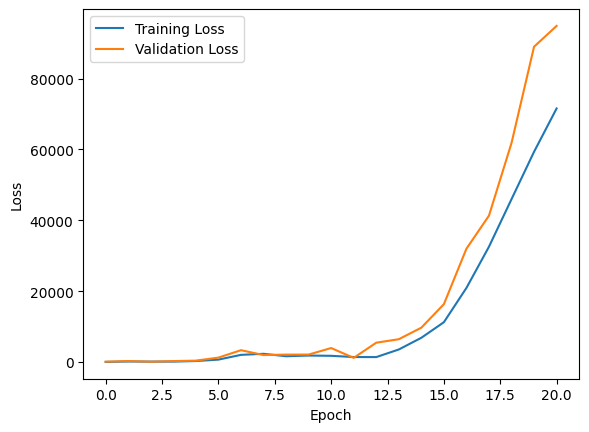

928/928 [==============================] - 119s 128ms/step - loss: 16641.1914 - accuracy: 0.5060 - precision_m: 0.8262 - recall_m: 0.2014 - f1_m: 0.3151

Performance for Training Set:
Accuracy: 0.506048
Precision: 0.826217
Recall: 0.201370
F1 Score: 0.315067

353/353 [==============================] - 43s 123ms/step - loss: 16322.2812 - accuracy: 0.6520 - precision_m: 0.4493 - recall_m: 0.3061 - f1_m: 0.3501

Performance for Validation Set:
Accuracy: 0.651958
Precision: 0.449329
Recall: 0.306122
F1 Score: 0.350122

401/401 [==============================] - 50s 123ms/step - loss: 16762.3711 - accuracy: 0.4901 - precision_m: 0.8039 - recall_m: 0.2930 - f1_m: 0.4213

Performance for Test Set:
Accuracy: 0.490135
Precision: 0.803949
Recall: 0.293022
F1 Score: 0.421287


In [13]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m, f1_m])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, 
                                                  start_from_epoch=15)

# Train the model
history = model.fit(tf_dataset_train,   # Augmentation was done during load_and_preprocess
                    epochs=30,
                    validation_data=tf_dataset_val,
                    callbacks=[early_stopping])

# Plot training and validation errors vs. epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
train_loss, train_acc, train_precision, train_recall, train_f1 = model.evaluate(tf_dataset_train)
print('\nPerformance for Training Set:')
print(f'Accuracy: {train_acc:4f}')
print(f'Precision: {train_precision:4f}')
print(f'Recall: {train_recall:4f}')
print(f'F1 Score: {train_f1:4f}\n')

val_loss, val_acc, val_precision, val_recall, val_f1 = model.evaluate(tf_dataset_val)
print('\nPerformance for Validation Set:')
print(f'Accuracy: {val_acc:4f}')
print(f'Precision: {val_precision:4f}')
print(f'Recall: {val_recall:4f}')
print(f'F1 Score: {val_f1:4f}\n')

test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(tf_dataset_test)
print('\nPerformance for Test Set:')
print(f'Accuracy: {test_acc:4f}')
print(f'Precision: {test_precision:4f}')
print(f'Recall: {test_recall:4f}')
print(f'F1 Score: {test_f1:4f}')

# Transfer Learning
## EfficientNetB0

Epoch 1/20
928/928 [==============================] - 522s 558ms/step - loss: 0.3435 - accuracy: 0.8545 - precision_m: 0.5878 - recall_m: 1.0000 - f1_m: 0.7364 - val_loss: 0.3224 - val_accuracy: 0.8962 - val_precision_m: 0.3217 - val_recall_m: 1.0000 - val_f1_m: 0.4809
Epoch 2/20
928/928 [==============================] - 519s 559ms/step - loss: 0.2800 - accuracy: 0.8807 - precision_m: 0.5878 - recall_m: 1.0000 - f1_m: 0.7367 - val_loss: 0.3663 - val_accuracy: 0.8739 - val_precision_m: 0.3218 - val_recall_m: 1.0000 - val_f1_m: 0.4809
Epoch 3/20
928/928 [==============================] - 501s 540ms/step - loss: 0.2714 - accuracy: 0.8827 - precision_m: 0.5878 - recall_m: 1.0000 - f1_m: 0.7366 - val_loss: 0.3129 - val_accuracy: 0.8851 - val_precision_m: 0.3218 - val_recall_m: 1.0000 - val_f1_m: 0.4809
Epoch 4/20
928/928 [==============================] - 498s 536ms/step - loss: 0.2659 - accuracy: 0.8866 - precision_m: 0.5878 - recall_m: 1.0000 - f1_m: 0.7368 - val_loss: 0.2734 - val_accur

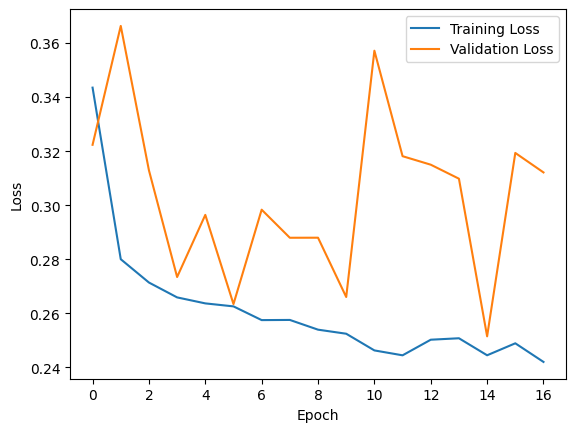

928/928 [==============================] - 357s 384ms/step - loss: 0.1993 - accuracy: 0.9204 - precision_m: 0.5878 - recall_m: 1.0000 - f1_m: 0.7365

Performance for Training Set:
Accuracy: 0.920415
Precision: 0.587763
Recall: 1.000000
F1 Score: 0.736493

353/353 [==============================] - 134s 378ms/step - loss: 0.2515 - accuracy: 0.9057 - precision_m: 0.3218 - recall_m: 1.0000 - f1_m: 0.4809

Performance for Validation Set:
Accuracy: 0.905724
Precision: 0.321771
Recall: 1.000000
F1 Score: 0.480884

401/401 [==============================] - 153s 382ms/step - loss: 0.1745 - accuracy: 0.9515 - precision_m: 0.6554 - recall_m: 1.0000 - f1_m: 0.7884

Performance for Test Set:
Accuracy: 0.951493
Precision: 0.655400
Recall: 1.000000
F1 Score: 0.788440


In [10]:
# Load the pre-trained EfficientNetB0 model
# base_model = EfficientNetB0(weights='../efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5', 
#                             include_top=False, input_shape=(299, 299, 3))
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers in the base model
base_model.trainable = False

# Create a new model on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax') 
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy', precision_m, recall_m, f1_m])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, 
                                                  start_from_epoch=10)

# Train the model
history = model.fit(tf_dataset_train,
                    epochs=20, 
                    validation_data=tf_dataset_val,
                    callbacks=[early_stopping])

# Plot training and validation errors vs. epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
train_loss, train_acc, train_precision, train_recall, train_f1 = model.evaluate(tf_dataset_train)
print('\nPerformance for Training Set:')
print(f'Accuracy: {train_acc:4f}')
print(f'Precision: {train_precision:4f}')
print(f'Recall: {train_recall:4f}')
print(f'F1 Score: {train_f1:4f}\n')

val_loss, val_acc, val_precision, val_recall, val_f1 = model.evaluate(tf_dataset_val)
print('\nPerformance for Validation Set:')
print(f'Accuracy: {val_acc:4f}')
print(f'Precision: {val_precision:4f}')
print(f'Recall: {val_recall:4f}')
print(f'F1 Score: {val_f1:4f}\n')

test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(tf_dataset_test)
print('\nPerformance for Test Set:')
print(f'Accuracy: {test_acc:4f}')
print(f'Precision: {test_precision:4f}')
print(f'Recall: {test_recall:4f}')
print(f'F1 Score: {test_f1:4f}')

## ResNet50

Epoch 1/20
928/928 [==============================] - 710s 762ms/step - loss: 0.5169 - accuracy: 0.7470 - precision_m: 0.5878 - recall_m: 1.0000 - f1_m: 0.7366 - val_loss: 0.6119 - val_accuracy: 0.6864 - val_precision_m: 0.3217 - val_recall_m: 1.0000 - val_f1_m: 0.4810
Epoch 2/20
928/928 [==============================] - 704s 759ms/step - loss: 0.4818 - accuracy: 0.7669 - precision_m: 0.5879 - recall_m: 1.0000 - f1_m: 0.7364 - val_loss: 0.5751 - val_accuracy: 0.7277 - val_precision_m: 0.3218 - val_recall_m: 1.0000 - val_f1_m: 0.4807
Epoch 3/20
928/928 [==============================] - 705s 760ms/step - loss: 0.4773 - accuracy: 0.7677 - precision_m: 0.5878 - recall_m: 1.0000 - f1_m: 0.7367 - val_loss: 0.5704 - val_accuracy: 0.7218 - val_precision_m: 0.3218 - val_recall_m: 1.0000 - val_f1_m: 0.4814
Epoch 4/20
928/928 [==============================] - 704s 759ms/step - loss: 0.4751 - accuracy: 0.7698 - precision_m: 0.5877 - recall_m: 1.0000 - f1_m: 0.7368 - val_loss: 0.5915 - val_accur

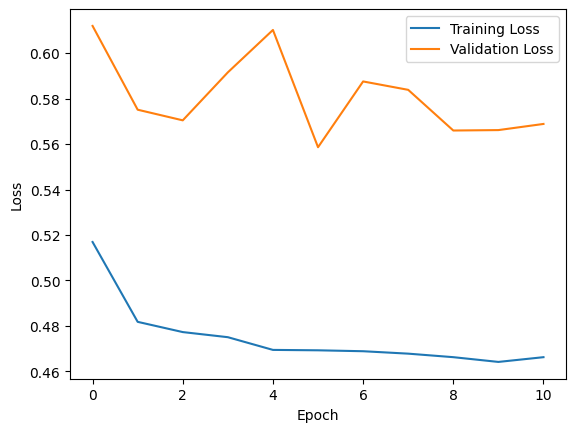

928/928 [==============================] - 512s 551ms/step - loss: 0.5251 - accuracy: 0.7397 - precision_m: 0.5879 - recall_m: 1.0000 - f1_m: 0.7369

Performance for Training Set:
Accuracy: 0.739681
Precision: 0.587877
Recall: 1.000000
F1 Score: 0.736860

353/353 [==============================] - 192s 543ms/step - loss: 0.5586 - accuracy: 0.7301 - precision_m: 0.3219 - recall_m: 1.0000 - f1_m: 0.4811

Performance for Validation Set:
Accuracy: 0.730108
Precision: 0.321892
Recall: 1.000000
F1 Score: 0.481109

401/401 [==============================] - 219s 546ms/step - loss: 0.5368 - accuracy: 0.7823 - precision_m: 0.6553 - recall_m: 1.0000 - f1_m: 0.7883

Performance for Test Set:
Accuracy: 0.782266
Precision: 0.655339
Recall: 1.000000
F1 Score: 0.788310


In [14]:
# Load the pre-trained ResNet50 model
# base_model = ResNet50(weights='../resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
#                       include_top=False, input_shape=(299, 299, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers in the base model
base_model.trainable = False

# Create a new model on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax') 
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy', precision_m, recall_m, f1_m])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, 
                                                  start_from_epoch=5)

# Train the model
history = model.fit(tf_dataset_train,
                    epochs=20,  
                    validation_data=tf_dataset_val,
                    callbacks=[early_stopping])

# Plot training and validation errors vs. epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
train_loss, train_acc, train_precision, train_recall, train_f1 = model.evaluate(tf_dataset_train)
print('\nPerformance for Training Set:')
print(f'Accuracy: {train_acc:4f}')
print(f'Precision: {train_precision:4f}')
print(f'Recall: {train_recall:4f}')
print(f'F1 Score: {train_f1:4f}\n')

val_loss, val_acc, val_precision, val_recall, val_f1 = model.evaluate(tf_dataset_val)
print('\nPerformance for Validation Set:')
print(f'Accuracy: {val_acc:4f}')
print(f'Precision: {val_precision:4f}')
print(f'Recall: {val_recall:4f}')
print(f'F1 Score: {val_f1:4f}\n')

test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(tf_dataset_test)
print('\nPerformance for Test Set:')
print(f'Accuracy: {test_acc:4f}')
print(f'Precision: {test_precision:4f}')
print(f'Recall: {test_recall:4f}')
print(f'F1 Score: {test_f1:4f}')

## VGG16

Epoch 1/20
928/928 [==============================] - 1011s 1s/step - loss: 0.4108 - accuracy: 0.8117 - precision_m: 0.5877 - recall_m: 1.0000 - f1_m: 0.7365 - val_loss: 0.5675 - val_accuracy: 0.7723 - val_precision_m: 0.3220 - val_recall_m: 1.0000 - val_f1_m: 0.4810
Epoch 2/20
928/928 [==============================] - 1006s 1s/step - loss: 0.3674 - accuracy: 0.8305 - precision_m: 0.5878 - recall_m: 1.0000 - f1_m: 0.7367 - val_loss: 0.5486 - val_accuracy: 0.7798 - val_precision_m: 0.3218 - val_recall_m: 1.0000 - val_f1_m: 0.4811
Epoch 3/20
928/928 [==============================] - 975s 1s/step - loss: 0.3610 - accuracy: 0.8329 - precision_m: 0.5876 - recall_m: 1.0000 - f1_m: 0.7361 - val_loss: 0.5033 - val_accuracy: 0.7938 - val_precision_m: 0.3216 - val_recall_m: 1.0000 - val_f1_m: 0.4801
Epoch 4/20
928/928 [==============================] - 1011s 1s/step - loss: 0.3547 - accuracy: 0.8349 - precision_m: 0.5878 - recall_m: 1.0000 - f1_m: 0.7366 - val_loss: 0.5202 - val_accuracy: 0.78

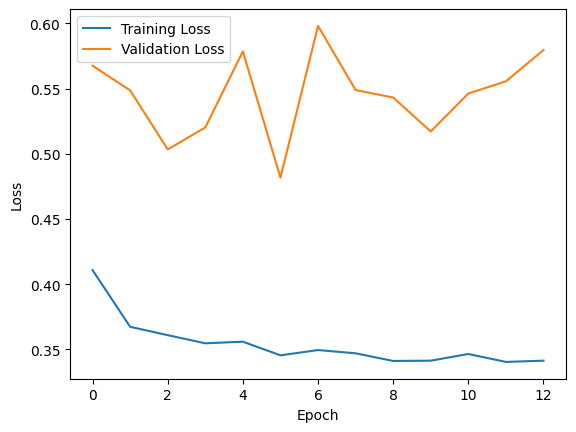

928/928 [==============================] - 704s 759ms/step - loss: 0.3036 - accuracy: 0.8642 - precision_m: 0.5878 - recall_m: 1.0000 - f1_m: 0.7365

Performance for Training Set:
Accuracy: 0.864214
Precision: 0.587763
Recall: 1.000000
F1 Score: 0.736492

353/353 [==============================] - 266s 753ms/step - loss: 0.5462 - accuracy: 0.7849 - precision_m: 0.3217 - recall_m: 1.0000 - f1_m: 0.4811

Performance for Validation Set:
Accuracy: 0.784866
Precision: 0.321691
Recall: 1.000000
F1 Score: 0.481098

401/401 [==============================] - 302s 753ms/step - loss: 0.2090 - accuracy: 0.9275 - precision_m: 0.6555 - recall_m: 1.0000 - f1_m: 0.7893

Performance for Test Set:
Accuracy: 0.927474
Precision: 0.655460
Recall: 1.000000
F1 Score: 0.789282


In [12]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='../vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                   include_top=False, input_shape=(299, 299, 3))
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers in the base model
base_model.trainable = False

# Create a new model on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax') 
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy', precision_m, recall_m, f1_m])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, 
                                                  start_from_epoch=10)

# Train the model
history = model.fit(tf_dataset_train,
                    epochs=20,  
                    validation_data=tf_dataset_val,
                    callbacks=[early_stopping])

# Plot training and validation errors vs. epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
train_loss, train_acc, train_precision, train_recall, train_f1 = model.evaluate(tf_dataset_train)
print('\nPerformance for Training Set:')
print(f'Accuracy: {train_acc:4f}')
print(f'Precision: {train_precision:4f}')
print(f'Recall: {train_recall:4f}')
print(f'F1 Score: {train_f1:4f}\n')

val_loss, val_acc, val_precision, val_recall, val_f1 = model.evaluate(tf_dataset_val)
print('\nPerformance for Validation Set:')
print(f'Accuracy: {val_acc:4f}')
print(f'Precision: {val_precision:4f}')
print(f'Recall: {val_recall:4f}')
print(f'F1 Score: {val_f1:4f}\n')

test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(tf_dataset_test)
print('\nPerformance for Test Set:')
print(f'Accuracy: {test_acc:4f}')
print(f'Precision: {test_precision:4f}')
print(f'Recall: {test_recall:4f}')
print(f'F1 Score: {test_f1:4f}')

# Performance Comparison on Test Set:
|           | CNN + MLP | EfficientNetB0 | ResNet50 | VGG16    |
|-----------|-----------|----------------|----------|----------|
| Accuracy  | 0.490135  | 0.951493       | 0.782266 | 0.927474 |
| Precision | 0.803949  | 0.655400       | 0.655339 | 0.655460 |
| Recall    | 0.293022  | 1.000000       | 1.000000 | 1.000000 |
| F1 Score  | 0.421287  | 0.788440       | 0.788310 | 0.789282 |

<br>Overall, `EfficientNetB0` and `VGG16` have the best result. On the other hand, `CNN + MLP` has the best result of precision.